<a href="https://colab.research.google.com/github/Prakruthi-B-R/Sentiment-Analysis-Using-ML/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle

In [2]:
# configuring the path of kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## *Importing* Twitter Sentiment Data

In [3]:
# API to fetch the dataset from kaggle
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 91% 74.0M/80.9M [00:00<00:00, 100MB/s] 
100% 80.9M/80.9M [00:00<00:00, 97.0MB/s]


In [4]:
# Extract the Dataset from CSV file
! unzip //content//sentiment140.zip

Archive:  //content//sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


*Importing Libraries*

In [5]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
# lets download stopwords from nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
# lets us print the stopwords
print(stopwords.words('english'))
print(len(stopwords.words('english')))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

# *Data Processing*

In [8]:
twitter_data= pd.read_csv('//content//training.1600000.processed.noemoticon.csv',encoding='latin-1',header=None)
twitter_data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
twitter_data.shape

(1600000, 6)

In [10]:
column_names = ["Target","ID","Date","Flag","User","Tweet"]
twitter_data.columns = column_names
twitter_data.head()

,Target,ID,Date,Flag,User,Tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [11]:
# checking for missing values
twitter_data.isnull().sum()

Target    0
ID        0
Date      0
Flag      0
User      0
Tweet     0
dtype: int64

In [12]:
# distribution of Target Column
twitter_data['Target'].value_counts()

Target
0    800000
4    800000
Name: count, dtype: int64

In [13]:
# convert the Target 4  to 1
twitter_data.replace({'Target':{4:1}},inplace=True)

In [14]:
twitter_data['Target'].value_counts()

Target
0    800000
1    800000
Name: count, dtype: int64

0-----> *Negative Tweet*

1-----> *Positive Tweet*

Stemming the Tweets

In [15]:
porter_stemmer = PorterStemmer()

In [16]:
def stemming(content):

    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [porter_stemmer.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)

    return stemmed_content

In [17]:
twitter_data['stemmed_content'] = twitter_data['Tweet'].apply(stemming)

In [18]:
twitter_data.head()

,Target,ID,Date,Flag,User,Tweet,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [19]:
# now let us drop unwanted columns
twitter_data.drop(["ID","Date","Flag","User","Tweet"],axis=1,inplace=True)

In [20]:
twitter_data

,Target,stemmed_content
0,0,switchfoot http twitpic com zl awww bummer sho...
1,0,upset updat facebook text might cri result sch...
2,0,kenichan dive mani time ball manag save rest g...
3,0,whole bodi feel itchi like fire
4,0,nationwideclass behav mad see
...,...,...
1599995,1,woke school best feel ever
1599996,1,thewdb com cool hear old walt interview http b...
1599997,1,readi mojo makeov ask detail
1599998,1,happi th birthday boo alll time tupac amaru sh...


In [21]:
# splitting the data into Input feature 'X' and output Target 'Y'
X= twitter_data['stemmed_content'].values
Y= twitter_data['Target'].values

In [22]:
print(X)

['switchfoot http twitpic com zl awww bummer shoulda got david carr third day'
 'upset updat facebook text might cri result school today also blah'
 'kenichan dive mani time ball manag save rest go bound' ...
 'readi mojo makeov ask detail'
 'happi th birthday boo alll time tupac amaru shakur'
 'happi charitytuesday thenspcc sparkschar speakinguph h']


In [23]:
print(Y)

[0 0 0 ... 1 1 1]


# Splitting the Data into Training data and Testing Data

In [24]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=2)

In [25]:
x_train.shape

(1280000,)

In [26]:
y_test.shape

(320000,)

# Feature Extraction Converting text data  into numeric

In [27]:
Vectorizer = TfidfVectorizer()

x_train_feature = Vectorizer.fit_transform(x_train)
x_test_feature = Vectorizer.transform(x_test)


In [28]:
print(x_train)


['watch saw iv drink lil wine' 'hatermagazin'
 'even though favourit drink think vodka coke wipe mind time think im gonna find new drink'
 ... 'eager monday afternoon'
 'hope everyon mother great day wait hear guy store tomorrow'
 'love wake folger bad voic deeper']


In [29]:
print(x_test)

['mmangen fine much time chat twitter hubbi back summer amp tend domin free time'
 'ah may show w ruth kim amp geoffrey sanhueza'
 'ishatara mayb bay area thang dammit' ...
 'destini nevertheless hooray member wonder safe trip' 'feel well'
 'supersandro thank']


In [30]:
print(x_train_feature)

  (0, 443066)	0.4484755317023172
  (0, 235045)	0.41996827700291095
  (0, 109306)	0.3753708587402299
  (0, 185193)	0.5277679060576009
  (0, 354543)	0.3588091611460021
  (0, 436713)	0.27259876264838384
  (1, 160636)	1.0
  (2, 288470)	0.16786949597862733
  (2, 132311)	0.2028971570399794
  (2, 150715)	0.18803850583207948
  (2, 178061)	0.1619010109445149
  (2, 409143)	0.15169282335109835
  (2, 266729)	0.24123230668976975
  (2, 443430)	0.3348599670252845
  (2, 77929)	0.31284080750346344
  (2, 433560)	0.3296595898028565
  (2, 406399)	0.32105459490875526
  (2, 129411)	0.29074192727957143
  (2, 407301)	0.18709338684973031
  (2, 124484)	0.1892155960801415
  (2, 109306)	0.4591176413728317
  (3, 172421)	0.37464146922154384
  (3, 411528)	0.27089772444087873
  (3, 388626)	0.3940776331458846
  (3, 56476)	0.5200465453608686
  :	:
  (1279996, 390130)	0.22064742191076112
  (1279996, 434014)	0.2718945052332447
  (1279996, 318303)	0.21254698865277746
  (1279996, 237899)	0.2236567560099234
  (1279996, 2910

In [31]:
print(x_test_feature)

  (0, 420984)	0.17915624523539803
  (0, 409143)	0.31430470598079707
  (0, 398906)	0.3491043873264267
  (0, 388348)	0.21985076072061738
  (0, 279082)	0.1782518010910344
  (0, 271016)	0.4535662391658828
  (0, 171378)	0.2805816206356073
  (0, 138164)	0.23688292264071403
  (0, 132364)	0.25525488955578596
  (0, 106069)	0.3655545001090455
  (0, 67828)	0.26800375270827315
  (0, 31168)	0.16247724180521766
  (0, 15110)	0.1719352837797837
  (1, 366203)	0.24595562404108307
  (1, 348135)	0.4739279595416274
  (1, 256777)	0.28751585696559306
  (1, 217562)	0.40288153995289894
  (1, 145393)	0.575262969264869
  (1, 15110)	0.211037449588008
  (1, 6463)	0.30733520460524466
  (2, 400621)	0.4317732461913093
  (2, 256834)	0.2564939661498776
  (2, 183312)	0.5892069252021465
  (2, 89448)	0.36340369428387626
  (2, 34401)	0.37916255084357414
  :	:
  (319994, 123278)	0.4530341382559843
  (319995, 444934)	0.3211092817599261
  (319995, 420984)	0.22631428606830145
  (319995, 416257)	0.23816465111736276
  (319995, 3

# Deploying Training data into the Machine Learning Model

In [32]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter = 1000)
model.fit(x_train_feature,y_train)

LogisticRegression(max_iter=1000)

# *Model Evaluation*

Accuracy of Training data

In [33]:
# Accuracy Score
from sklearn.metrics import accuracy_score
x_train_prediction = model.predict(x_train_feature)
training_data_accuracy = accuracy_score(x_train_prediction,y_train)
print('Accuracy score on training data : ',training_data_accuracy)

Accuracy score on training data :  0.81018984375


Accuracy of Testing data

In [34]:
y_predict = model.predict(x_test_feature)
test_data_accuracy = accuracy_score(y_predict,y_test)
print('Accuracy score on test data : ',test_data_accuracy)

Accuracy score on test data :  0.7780375


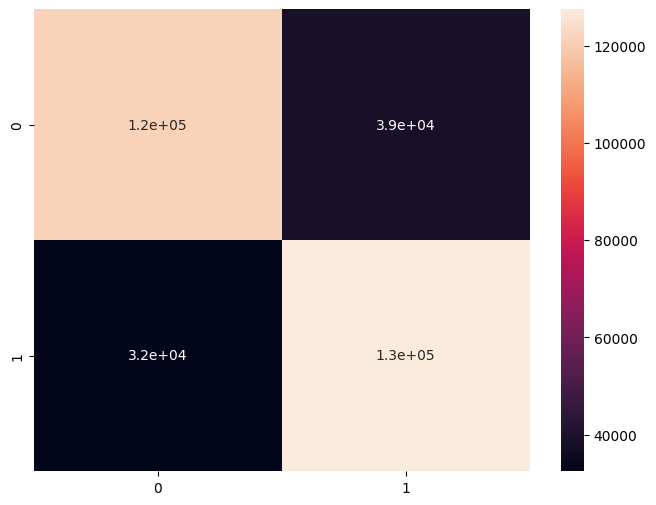

In [35]:
from matplotlib import pyplot as plt
import seaborn  as sns
from sklearn.metrics import confusion_matrix
plt.figure(figsize =(8,6))
sns.heatmap(confusion_matrix(y_test,y_predict),annot=True)
plt.show()

Model Accuracy = 77.80%

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.79      0.76      0.77    160000
           1       0.77      0.80      0.78    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



# Deploying training data into SVM Model

In [37]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(loss='hinge', max_iter=1000)
model.fit(x_train_feature, y_train)

SGDClassifier()

# *Model Evaluation*

In [38]:
# find the accuracy of the test data
y_predict = model.predict(x_test_feature)
Accuracy = classification_report(y_test,y_predict)
print(Accuracy)

              precision    recall  f1-score   support

           0       0.79      0.69      0.74    160000
           1       0.73      0.82      0.77    160000

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.75    320000
weighted avg       0.76      0.76      0.75    320000



# Deploying Training Data into Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier
model_1 = RandomForestClassifier(n_estimators = 100, max_depth = 10)
model_1.fit(x_train_feature,y_train)

RandomForestClassifier(max_depth=10)

# Accuracy Test of RF Model

In [40]:
y1_predict = model_1.predict(x_test_feature)
Accuracy = classification_report(y_test,y1_predict)
print(Accuracy)

              precision    recall  f1-score   support

           0       0.72      0.65      0.68    160000
           1       0.68      0.75      0.72    160000

    accuracy                           0.70    320000
   macro avg       0.70      0.70      0.70    320000
weighted avg       0.70      0.70      0.70    320000

